In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

from tensorflow.keras.preprocessing import image
from keras.models import load_model

from skimage.morphology import skeletonize
from skan import csr
from skimage import exposure

In [2]:
import tensorflow as tf
import keras.backend as K

In [3]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE)
    
    return padded_image

### Loading the model

In [4]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        threshold = 0.5 
        y_pred_binary = K.round(y_pred + 0.5 - threshold)
        
        intersection = K.sum(K.abs(y_true * y_pred_binary), axis=[1,2,3])
        total = K.sum(K.square(y_true), [1,2,3]) + K.sum(K.square(y_pred_binary), [1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    
    return K.mean(f(y_true, y_pred), axis=-1)

In [6]:
# Load the best model saved during training, providing custom metrics
model_1 = load_model("occlusion_2.h5", custom_objects={'f1': f1, 'iou': iou})

In [7]:
# Load the best model saved during training, providing custom metrics
model_2 = load_model("occlusion_mm_4.h5", custom_objects={'f1': f1, 'iou': iou})

## multiple model prediction on uncropped image

**NOTE:** I still need to check it better because it shouldn't be different but I want to compare the exact same model with same number of iterations on the same image cropped and uncropped to compare the performance

In [40]:
def process_images_in_folder_w_refinement_uncropped(folder_path, num_images, refinement_steps, model, patch_size=256):
    # Get a list of all image files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.tif', '.jpeg'))]

    # Select a random sample of image files
    selected_files = np.random.choice(image_files, num_images, replace=False)

    for image_file in selected_files:
        # Construct the full path of the image file
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        padded_image = padder(image, patch_size)
        
        # Initialize the image to be used for prediction
        image_for_prediction = padded_image.copy()

        for _ in range(refinement_steps + 1):  # +1 to include the initial prediction
            # Preparing patches for prediction
            patches = patchify(image_for_prediction, (patch_size, patch_size), step=patch_size)
            patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)
            
            # Predict with the model
            preds = model.predict(patches_reshaped / 255.0)

            root_predictions_reshaped = preds.reshape(patches.shape[0], patches.shape[1], patch_size, patch_size)
            predicted_mask = unpatchify(root_predictions_reshaped, padded_image.shape)
            predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Thresholding to create a binary mask

            # Use the predicted mask for the next iteration
            image_for_prediction = predicted_mask * 255  # Scale back up for prediction

        # Calculate the difference mask
        difference_mask = np.not_equal(padded_image > 0.5, predicted_mask)

        # Create an RGB version of the original image
        rgb_image = np.stack([padded_image] * 3, axis=-1)

        # Overlay the difference in blue
        blue_overlay = np.zeros_like(rgb_image)
        blue_overlay[:, :, 2] = difference_mask * 255  # Set blue channel to 255 where there is a difference
        rgb_difference = np.maximum(rgb_image, blue_overlay)

        #Saving the rgb_difference
        cv2.imwrite(f"predicted_mask_{image_file}", (rgb_difference).astype(np.uint8))

        # Saving the padded image
        cv2.imwrite(f"padded_image_{image_file}", padded_image)

     

        # Plot the images with the image file name as the title
        fig, ax = plt.subplots(1, 3, figsize=(20, 6))
        ax[0].imshow(padded_image, cmap="gray")
        ax[1].imshow(predicted_mask, cmap="gray")
        ax[2].imshow(rgb_difference)
        #ax[3].imshow(predicted_mask, cmap="hot")  # Assuming this is for enhanced visualization
        ax[0].axis("off")
        ax[0].set_title("Original image")
        ax[1].axis("off")
        ax[1].set_title(f"Predicted root mask - {image_file[:-32]}...")
        ax[2].axis("off")
        ax[2].set_title(f"Difference")
        #ax[3].axis("off")
        #ax[3].set_title("Skeleton Contrast Adjusted")

        plt.show()



2/2 [==============================] - 0s 349ms/step


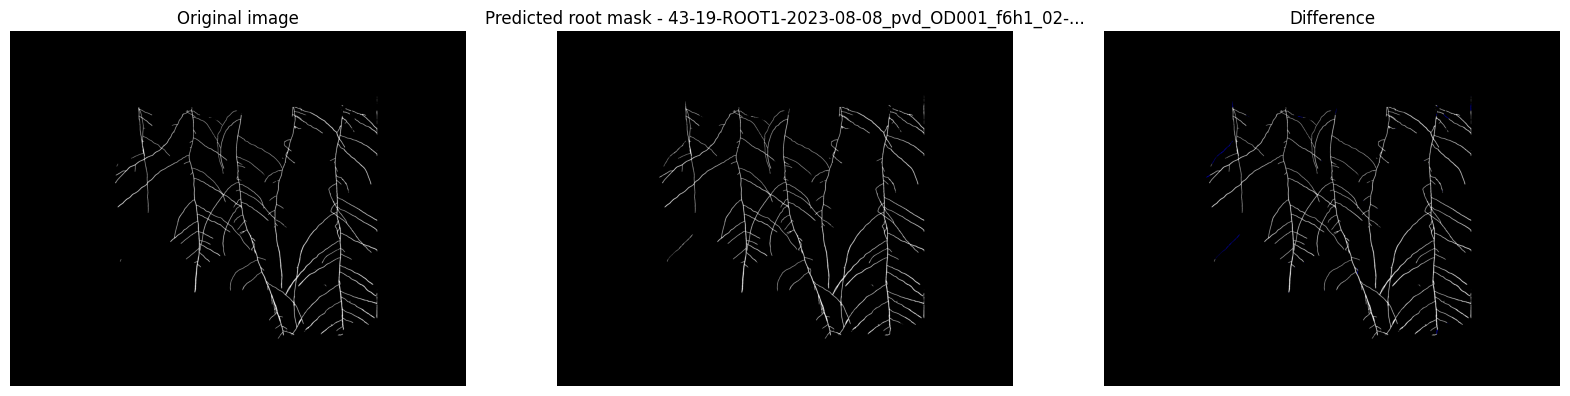

In [41]:
folder_path = 'presentation_uncropped'
num_images = 1

process_images_in_folder_w_refinement_uncropped(folder_path, num_images, refinement_steps=50, model=model_1, patch_size=512)

In [17]:
# Load the best model saved during training, providing custom metrics
model_3 = load_model("models/discontinuity_patcher.h5", custom_objects={'f1': f1, 'iou': iou})

8/8 [==============================] - 1s 131ms/step


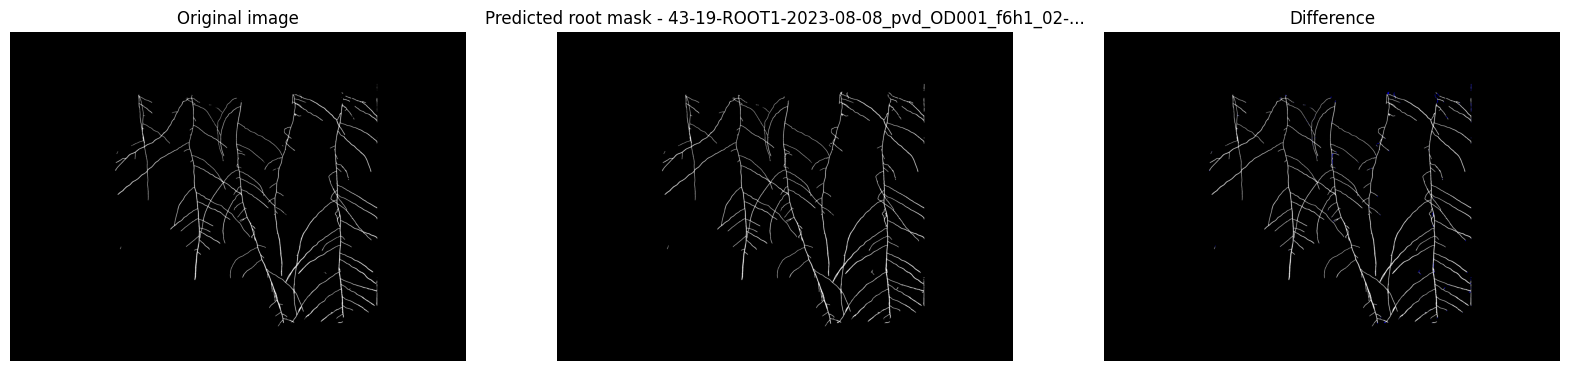

In [45]:
folder_path = 'presentation_uncropped'
num_images = 1

process_images_in_folder_w_refinement_uncropped(folder_path, num_images, refinement_steps=0, model=model_3, patch_size=256)

## multiple model prediction on cropped image

In [ ]:
def process_images_in_folder_w_refinement(folder_path, num_images, refinement_steps, model, patch_size=256):
    # Get a list of all image files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.tif', '.jpeg'))]

    # Select a random sample of image files
    selected_files = np.random.choice(image_files, num_images, replace=False)

    for image_file in selected_files:
        # Construct the full path of the image file
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Assume 'padder' function is defined elsewhere to adjust image dimensions as needed
        #patch_size = 256
        image = padder(image, patch_size)  # Adjust the image size as required
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        i, j = patches.shape[0], patches.shape[1]
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        # Initial prediction
        preds = model.predict(patches / 255)
        
        # Iteratively refine predictions
        for _ in range(refinement_steps):
            # Reshape predictions to match the patches layout, then predict again
            refined_patches = preds.reshape(-1, patch_size, patch_size, 1)
            preds = model.predict(refined_patches)
            preds = preds > 0.5  # Apply threshold to get binary mask

        # Final processing of predictions
        preds = preds.reshape(i, j, patch_size, patch_size)
        predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
        predicted_mask = predicted_mask > 0.5  # Apply threshold to get binary mask

        # Calculate the difference mask
        difference_mask = np.not_equal(image > 0.5, predicted_mask)

        # Create an RGB version of the original image
        rgb_image = np.stack([image] * 3, axis=-1)

        # Overlay the difference in blue
        blue_overlay = np.zeros_like(rgb_image)
        blue_overlay[:,:,0] = difference_mask * 255  # Set blue channel to 255 where there is a difference
        rgb_difference = np.maximum(rgb_image, blue_overlay)

        # Skeletonize the predicted mask
        skeleton = skeletonize(predicted_mask)

        # Adjust the contrast of the skeleton. This step is optional and can be adjusted or omitted.
        # Here, we're using skimage's exposure module to rescale the intensities to enhance visibility.
        # Since the skeleton is binary, this step may not have a significant effect without changing the plotting approach.
        skeleton_contrast_adjusted = exposure.rescale_intensity(skeleton.astype(np.float32), in_range=(0, 1), out_range=(0.5, 1))

        # Plot the images with the image file name as the title
        fig, ax = plt.subplots(1, 4, figsize=(20, 6))  # Changed 3 to 4 here
        ax[0].imshow(image, cmap="gray")
        ax[1].imshow(predicted_mask, cmap="gray")
        ax[2].imshow(rgb_difference)  # Using a different colormap for enhanced visibility
        ax[3].imshow(skeleton_contrast_adjusted, cmap="hot")  # New image for skeleton contrast adjusted
        ax[0].axis("off")
        ax[0].set_title("Original image")
        ax[1].axis("off")
        ax[1].set_title(f"Predicted root mask - {image_file[:-32]}...")
        ax[2].axis("off")
        ax[2].set_title(f"Difference")
        ax[3].axis("off")  # Turn off axis for the new image
        ax[3].set_title("Skeleton Contrast Adjusted")  # Title for the new image

        plt.show()